In [23]:
from dataclasses import dataclass
import dateutil.parser
import json
import re

@dataclass
class SampleContainerStats:
    BlockIO: str
    CPUPerc: str
    Container: str
    ID: str
    MemPerc: str
    MemUsage: str
    Name: str
    NetIO: str
    PIDs: str    
    
    def getContainerName(self) -> str:
        return self.Name
    
    def getCPUPercent(self) -> float:
        return float(self.CPUPerc.replace('%', ''))

    def getMemPercent(self) -> float:
        return float(self.MemPerc.replace('%', ''))
    
    def getRawDiskIORW(self) -> tuple[str, str]:
        return [item.strip() for item in self.BlockIO.split("/", 1)]
    
    def getRawDiskIORead(self) -> str:
        return self.getRawDiskIORW()[0]
    
    def getRawDiskIOWrite(self) -> str:
        return self.getRawDiskIORW()[1]
    
    def getDiskIORead(self) -> int:
        return self._getSimpleUnitsValue(self.getRawDiskIORead())
    
    def getDiskIOWrite(self) -> int:
        return self._getSimpleUnitsValue(self.getRawDiskIOWrite())
            
    def _getSimpleUnitsValue(self, rawValue: str) -> int:
        [n, unit] = self._parseNumberWithUnit(rawValue)
        multiplier = self._getMultiplier(unit)

        return n * multiplier
    
    def _parseNumberWithUnit(self, numberWithUnit: str) -> tuple[float, str]:
        m = re.match('(\d+(?:\.\d+)?)(\w+B)', numberWithUnit)
        if m is None:
            raise ValueError(f'Number parse is failed: {0}'.format(numberWithUnit) )
        
        return (float(m.group(1)), m.group(2))
    
    def _getMultiplier(self, unit: str) -> int:
        match(unit.lower()):
            case "kib":
                return 2**10
            case "kb":
                return 10**3
            case "mib":
                return 2**20
            case "mb":
                return 10**6
            case "gib": 
                return 2**30
            case "gb":
                return 10**9
            
        raise ValueError("Unknown unit")

    
@dataclass
class SampleRow():
    dt: str
    exitCode: int
    data: list

    def getTimestamp(self):
        return dateutil.parser.isoparse(self.dt)
    
    def getItems(self) -> list[SampleContainerStats]:
        return [SampleContainerStats(**dataItem) for dataItem in self.data]

    def getItemByContainerName(self, containerName) -> SampleContainerStats | None: 
        items = self.getItems()
        res = [item for item in items if item.getContainerName() == containerName]
        
        return res[0] if len(res)>0 else None

            
class SampleData:
    rows: list[SampleRow]

    def __init__(self, rows):
        self.rows = rows
    
    def getRows(self) -> list[SampleRow]:
        return self.rows
    
class SampleDataLoader:
    @staticmethod
    def load(filename):
        rows = []
    
        with open(filename) as f:        
            for rowJSON in f.readlines():
                sampleRow = json.loads(rowJSON)
                rows.append(SampleRow(**sampleRow))

        return SampleData(rows)

In [24]:
import matplotlib.pyplot as plt
import re
import datetime
from typing import Callable

class SampleDataCollection:
    def __init__(self, data: SampleData):
        self.data = data

    def getSampleRows(self) -> list[SampleRow]:
        return self.data.getRows()
    
    def getContainerNames(self, filter: Callable[[str], bool]|None=None) -> list[str]:
        res = {}

        if filter is None:
            filter = lambda _: True

        for sampleRow in self.getSampleRows():
            for item in sampleRow.getItems():
                res[item.getContainerName()] = True

        return [item for item in res.keys() if filter(item)]
    
    def getContainerSamples(self, containerName: str) -> list[tuple[datetime.datetime, SampleContainerStats]]:
        res = []
        for sampleRow in self.getSampleRows():
            dt = sampleRow.getTimestamp()
            stats = sampleRow.getItemByContainerName(containerName)
            res.append((dt, stats))

        return res

class SampleDataGraphs:
    def render(self, fig: plt.Figure, sampleData: SampleDataCollection, containerNameFilter: Callable[[str], bool]):
        plot_cpu = fig.add_subplot(2, 2, 1)
        plot_mem = fig.add_subplot(2, 2, 2)
        plot_disk_read = fig.add_subplot(2, 2, 3)
        plot_disk_write = fig.add_subplot(2, 2, 4)
        for containerName in sampleData.getContainerNames(containerNameFilter):
            items = sampleData.getContainerSamples(containerName)

            timestamps = [item[0] for item in items]
            cpuPercents = [item[1].getCPUPercent() for item in items]
            memPercents = [item[1].getMemPercent() for item in items]
            diskIORead = [item[1].getDiskIORead() / 2**20 for item in items]
            diskIOWrite = [item[1].getDiskIOWrite() / 2**20 for item in items]

            plot_cpu.plot(timestamps, cpuPercents, label=containerName)
            plot_mem.plot(timestamps, memPercents, label=containerName)
            plot_disk_read.plot(timestamps, diskIORead, label=containerName)
            plot_disk_write.plot(timestamps, diskIOWrite, label=containerName)

        plot_cpu.set_title("CPU usage, %")
        plot_cpu.legend(loc='center right')
        plot_mem.set_title("Mem usage, %")
        plot_mem.legend(loc='center right')
        plot_disk_read.set_title("Disk IO (read, MiB total)")
        plot_disk_read.legend(loc='center right')
        plot_disk_write.set_title("Disk IO (write, MiB total)")
        plot_disk_write.legend(loc='center right')


## Master reads

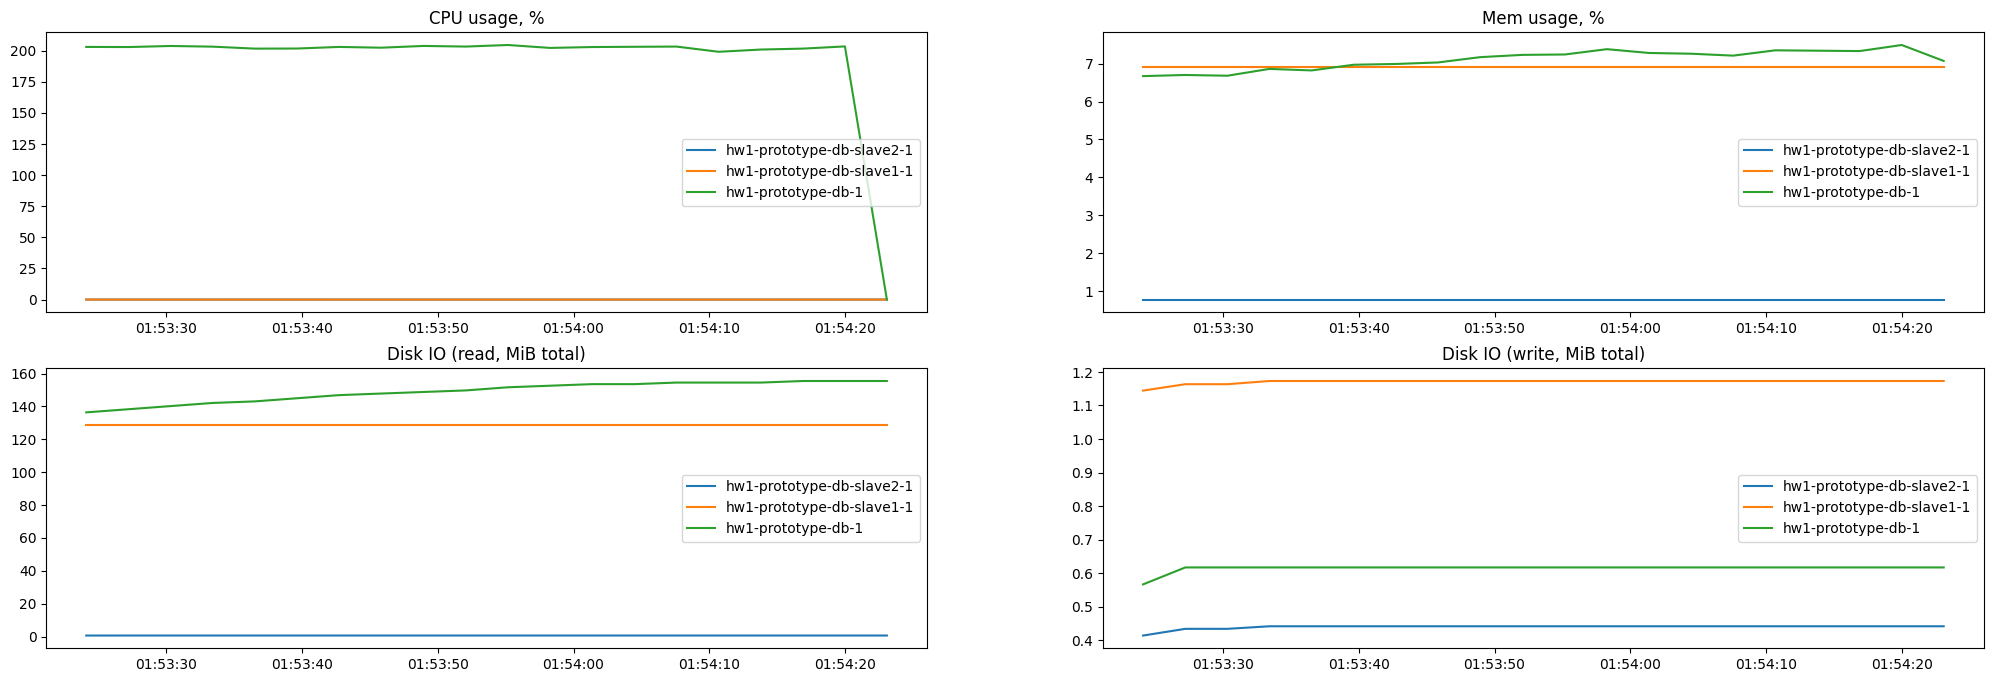

In [25]:
import os

rawSampleData = SampleDataLoader.load(os.path.abspath('responses-master.jsonl'))

graphs = SampleDataGraphs()
graphs.render(
    plt.figure(figsize=(25,8)), 
    sampleData=SampleDataCollection(rawSampleData),
    containerNameFilter = lambda name: re.search('^hw1-prototype-db', name)
)
plt.show()


# Slave-1 reads

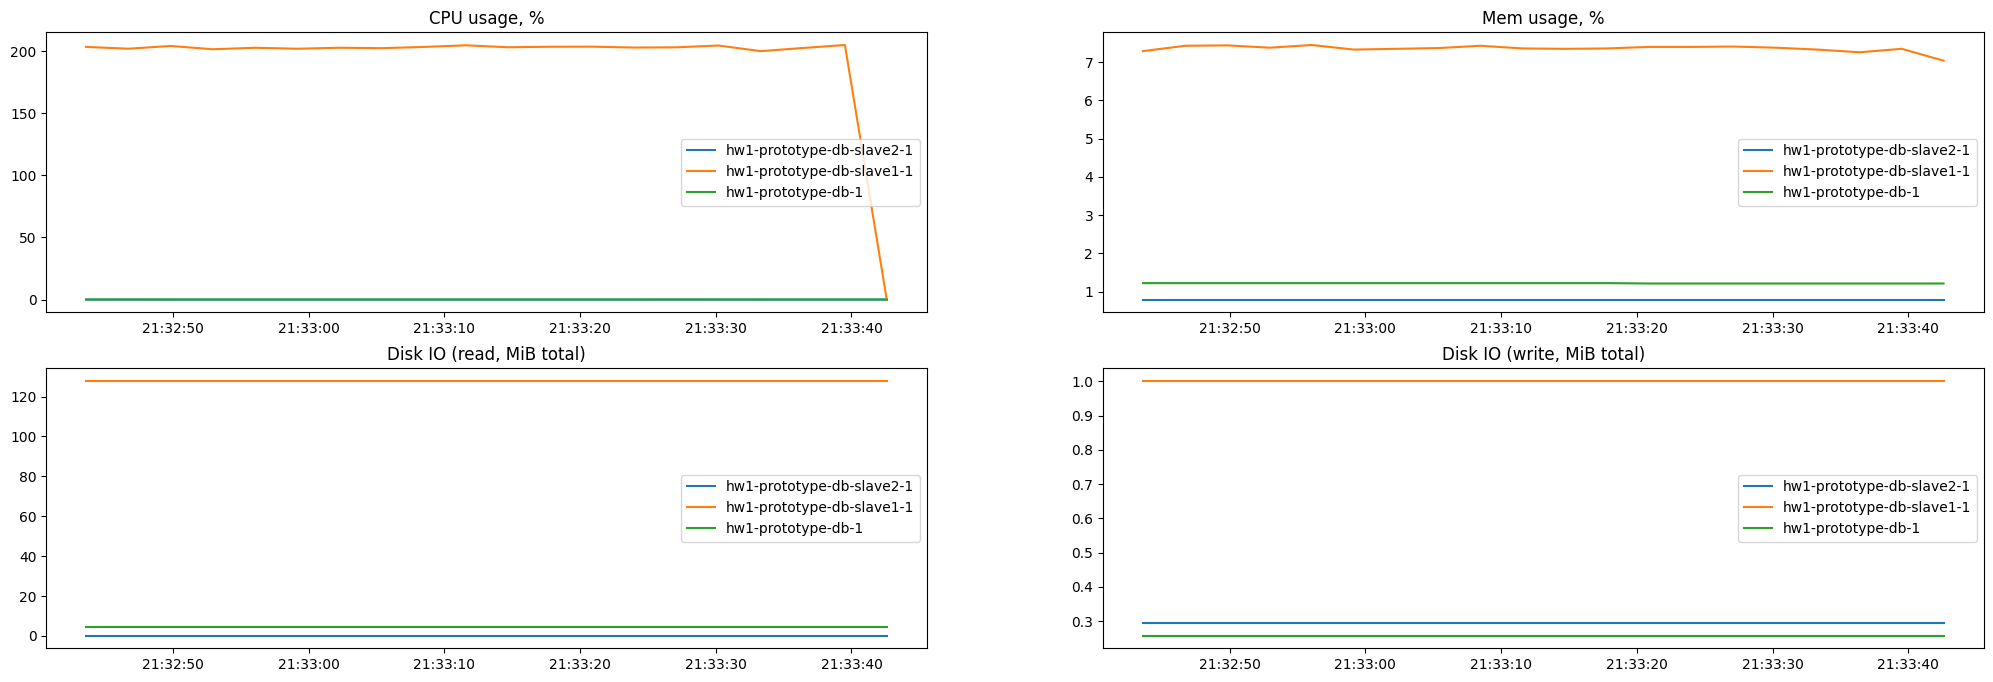

In [26]:
import os;

rawSampleData = SampleDataLoader.load(os.path.abspath('responses-slave1.jsonl'))

graphs = SampleDataGraphs()
graphs.render(
    plt.figure(figsize=(25,8)), 
    sampleData=SampleDataCollection(rawSampleData),
    containerNameFilter = lambda name: re.search('^hw1-prototype-db', name)
)
plt.show()